In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook


We here minimize $$f(x)= \frac{x^2}{x^2+a}.$$ The smaller $a$ the more curved becomes the valley. The second derivative writes as follows
$$f^{\prime\prime}(x)=\frac{(2 a (a - 3 x^2))}{(a + x^2)^3}.$$
For $a>0$ we have $$-\frac{1}{2a}\leq f^{\prime\prime}(x)\leq \frac{2}{a}\:\:\:,\forall x\in\mathbb{R}$$
from which we can deduce that the Lipschitz constant of the gradients is $L=2/a$.

### Run methods

step_size -0.099


<IPython.core.display.Javascript object>


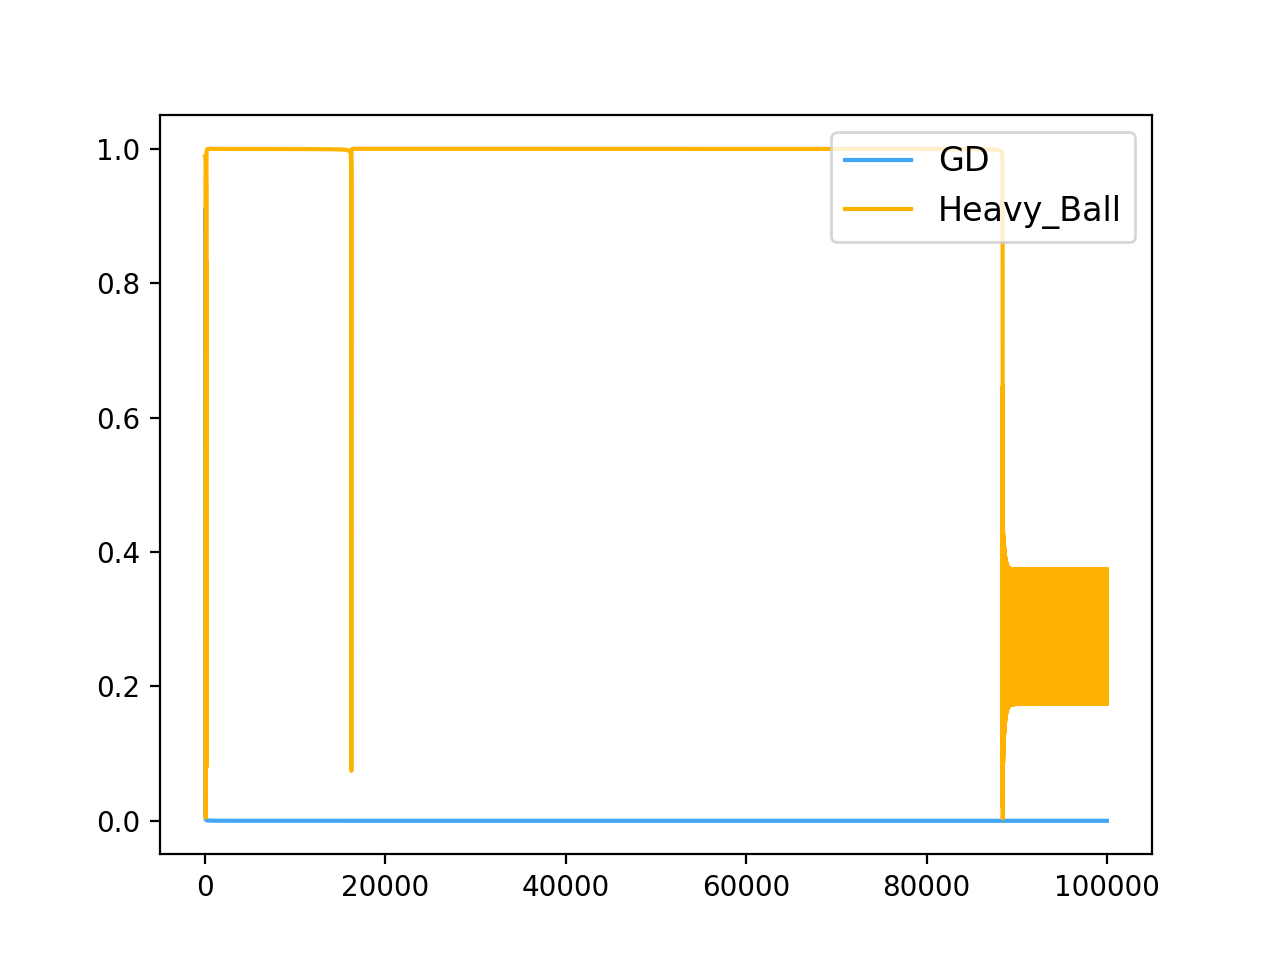

<IPython.core.display.Javascript object>


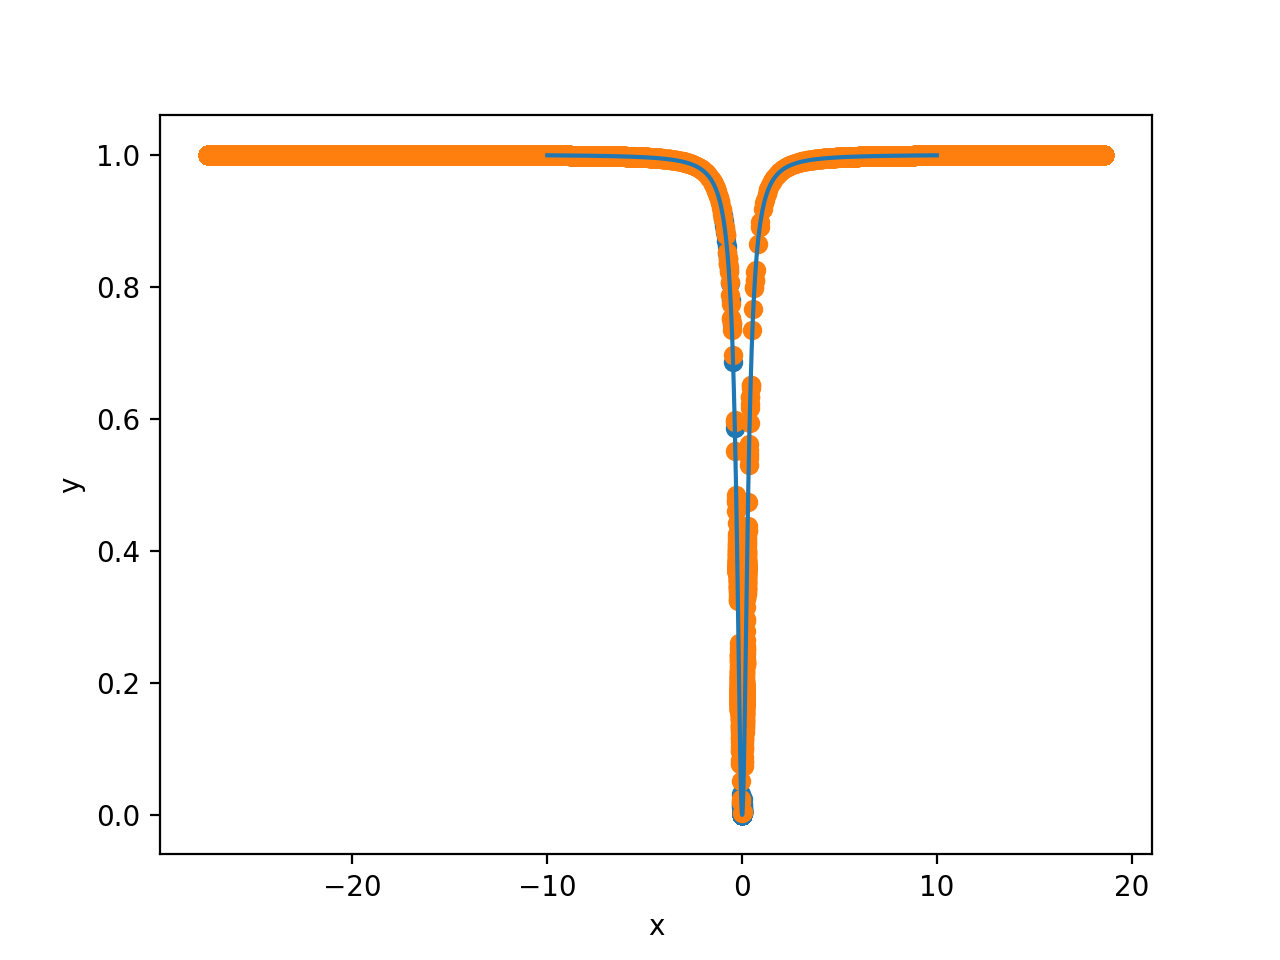

last iterate of HB -0.24445984599090106


In [61]:
# no_of_runs=1
global a
a=0.1
lipschitz=2/a
momentum=0.99
step_size=2*(1-momentum)/lipschitz-0.1
print('step_size', step_size)


iterations=100000
accuracy=1e-10
step_size=0.1
no_of_runs=1

global loss_type, log_loss
log_loss=False


loss_type='1d'
list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((-10,10))

GD=True
PGD=False
AGD=False
PAGD=False
Momentum=True



w_0=-3


if GD:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(-1,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD')
    list_steps.append(GD_steps)
 
if AGD:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy,momentum)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)
 
if Heavy_Ball:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (Heavy_Ball_steps,_x,_loss,momentum_magnitudes)= Heavy_Ball(w_0,iterations,step_size,accuracy,momentum)
        loss_collector.append(_loss)
        x_collector.append(_x)
    Heavy_Ball_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Heavy_Ball_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(Heavy_Ball_loss)
    list_x.append(Heavy_Ball_x)
    list_methods.append('Heavy_Ball')
    list_steps.append(Heavy_Ball_steps)

    
make_plot(list_loss,list_x,list_methods,list_steps,limits)
print('last iterate of HB', Heavy_Ball_steps[-1])


<IPython.core.display.Javascript object>


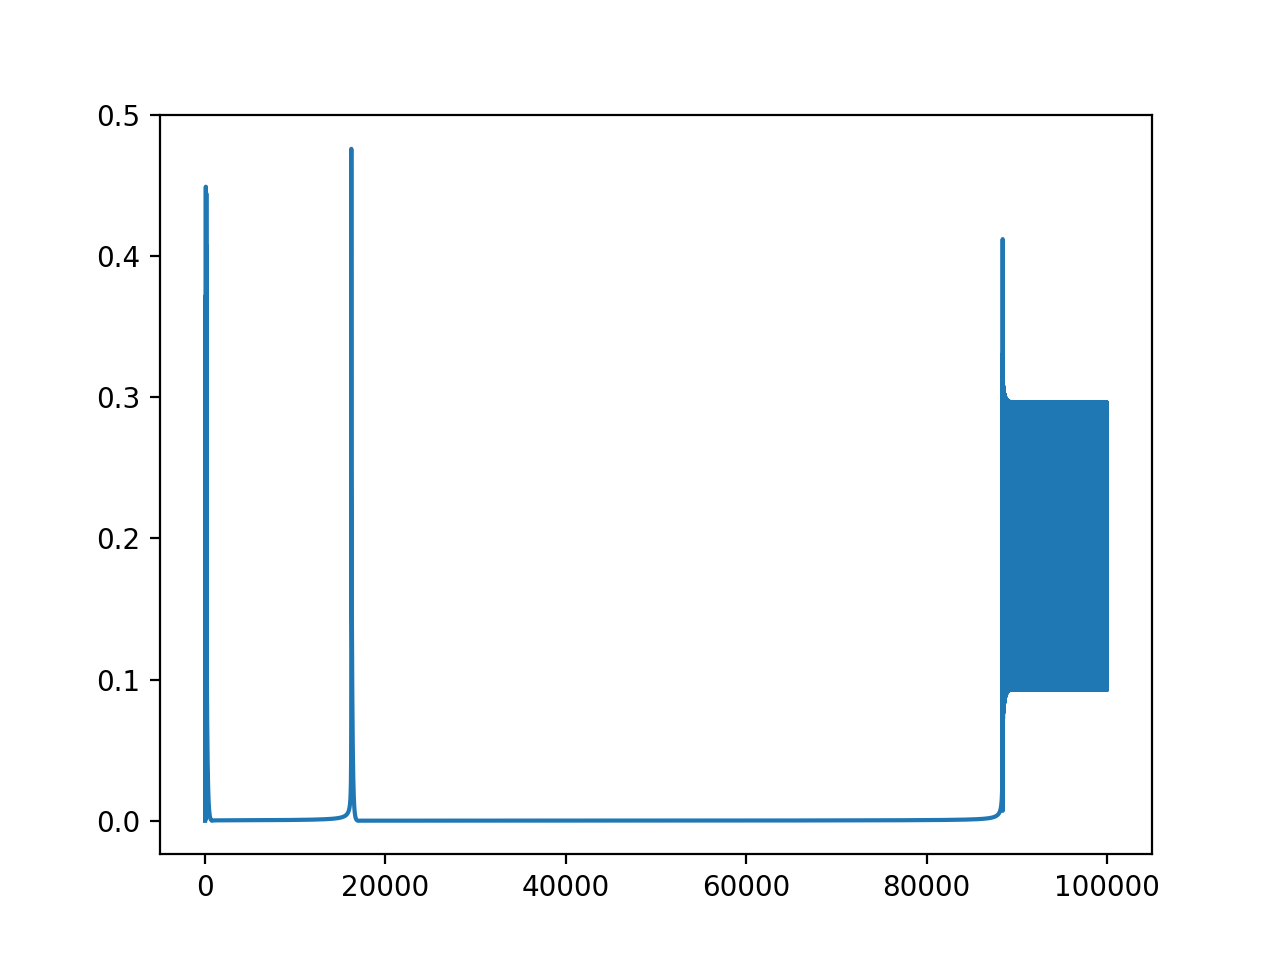

In [62]:
plt.figure(5)

plt.plot(range(0,len(momentum_magnitudes)),momentum_magnitudes )


### some necessary functions:

In [21]:
 def compute_loss(w):
        
    if loss_type=='1d':
        loss= y=(w**2)/(w**2+a)      
    else:
        raise ValueError("Unknown losstype!")
    
    return loss

def compute_gradients(w):
# forward pass

    if loss_type=='1d':
        grad= (2*a*w)/(a + w**2)**2
    else:
        raise ValueError("Unknown losstype!")
        
    return grad



def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']
    

    s=0.01
    t1 = np.arange(limits[0], limits[1], s)

    if log_loss:
        #overall min value
        min_value=1000
        for k in range(len(list_loss)):
            min_value = min(list_loss[k]) if (min(list_loss[k])<=min_value) else min_value
        #subtract min value from all values and add epsilon
        eps = min_value*1e-6
        for k in range(len(list_loss)):
            list_loss[k]= [i - min_value+eps  for i in list_loss[k]]

    #2. Plot performance over time/steps
    plt.figure(1)

    plt.plot()
    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)
      
    if log_loss:
        plt.yscale('log')
    else: 
        plt.yscale('linear')
    #3 .Plot Error Surface
    plt.figure(2)
    plt.plot(t1, (t1**2)/(t1**2+a))

    # Show iterates
    for i in range(len(list_loss)):
        plt.scatter(list_steps[i],list_loss[i])

        

    plt.xlabel('x')
    plt.ylabel('y')



### Gradient Descent

In [20]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad


    return(iterates,x,loss)

### Accelerated Gradient Descent

In [19]:
#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy,momentum):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        #y=w+(k-1)/(k+2)*(w-w_old)
        y=w+momentum*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        if loss_type=='tube': #if no mirroring trick is used in gradients. apply here!
            if w[1]<0:
                print(' neg x_2')
            #    w[1]=-w[1]


    return(iterates,x,loss)

### Momentum

In [45]:
#Run Momentum
def Heavy_Ball(w,iterations,step_size, accuracy,momentum):
    iterates=[]
    loss=[]
    momentum_magnitudes=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        #y=w+(k-1)/(k+2)*(w-w_old)
        y=w+momentum*(w-w_old)
        momentum_magnitudes.append(np.abs(w-w_old))
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(w)
        w=y-step_size*grad
 
    return(iterates,x,loss, momentum_magnitudes)